This script has been modified with Ben in order to not use the weighting function of histogram. 

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker


In [77]:
def plot_fracture_orientation_largest_eigenvector_step(expn, idx_ani, thr_ani, idx_phi, idx_vol, idx_theta, idx_diff, limvolinf, limvolsup, step, ext, shrs, vmin, vmax):
    for i, expns in enumerate(expn):
        file_path = os.path.join('C:\\Users\\erinap\\OneDrive - Universitetet i Oslo\\Documents\\PhD\\# Data to work on\\2022_WGN\\txts', f'{expns}_fracprops_32bit_cropped.txt')

        # Read the file into a NumPy array
        data_array = np.loadtxt(file_path, skiprows=1)
        unique_values = np.unique(data_array[:, 0])
        sigd = np.unique(data_array[:, idx_diff])
        idxs = unique_values
        odd_idxs = idxs[0::step] 

        # Set up a figure with subplots for each odd index of idxs
        rows = len(odd_idxs) // 4 + (1 if len(odd_idxs) % 4 != 0 else 0)
        fig, axs = plt.subplots(rows, 4, subplot_kw=dict(polar=True), figsize=(15, 5 * rows))
        cbar_axs = []
        
        phi1_ext_list = []
        phi1_shrs_list = []
        ptg_ext_list = []
        ptg_shr_list = []
        sigdx_list = []
        phi1_len = []
        tot_vol_ext_list = []
        tot_vol_shrs_list = []
        vol_fracs = []

        for j, idx in enumerate(odd_idxs):
            subset_data = data_array[data_array[:, 0] == unique_values[int(idx-1)], :]
            sigdx = round(sigd[int(idx-1)], 1)
            sigdx_list.append(sigdx)
            indstmp = np.logical_and(np.log10(subset_data[:, idx_vol])>limvolinf, np.log10(subset_data[:, idx_vol])<limvolsup) # DEFINES THE CRACKS OF INTEREST IN THE CORRECT VOLUME RANGE
            filtered_vol = subset_data[indstmp]
                
            # filtered the anisotropy
            anisotropy_filter = filtered_vol[:, idx_ani] > thr_ani
            final_filtered_data = filtered_vol[anisotropy_filter]
            
            phi1 = final_filtered_data[:, idx_phi]
            phi1_len.append(len(phi1))
            
            # Calculate the total volume for phi1 < ext
            tot_vol_ext = np.sum(final_filtered_data[phi1 < ext, idx_vol])
    
            # Calculate the total volume for phi1 >= ext and phi1 <= shrs
            tot_vol_shrs = np.sum(final_filtered_data[(phi1 >= ext) & (phi1 <= shrs), idx_vol])
    
            # Append the total volumes to the list
            tot_vol_ext_list.append(tot_vol_ext)
            tot_vol_shrs_list.append(tot_vol_shrs)
            
            # this is for showing the number of extensile and shear cracks
            # Check for zero sum in the subset_data[:, idx_vol][indstmp]
            if np.sum(final_filtered_data[:, idx_vol]) == 0:
                print(f'Sum of subset_data is zero for {expns} at index {idx-1}, skipping this iteration.')
                phi1_ext = 0
                ptg_ext = 0
                phi1_shrs = 0
                ptg_shr = 0
            else:
                phi1_ext = np.sum(phi1<ext)
                ptg_ext = phi1_ext/len(phi1)
                phi1_shrs = np.sum(np.logical_and(phi1>=ext,phi1<=shrs))
                ptg_shr = phi1_shrs/len(phi1)
            
            # Append to the list
            phi1_ext_list.append(phi1_ext)
            phi1_shrs_list.append(phi1_shrs)
            ptg_ext_list.append(ptg_ext)
            ptg_shr_list.append(ptg_shr)
            
            
            theta1 = final_filtered_data[:, idx_theta]
            theta1[theta1 < 0] += 360
            
            vol_fracs.append(np.sum(final_filtered_data[:, idx_vol]))
            # weights = final_filtered_data[:, idx_vol] / np.sum(final_filtered_data[:, idx_vol])
           
            # Prepare histogram
            discreti = 2

            phi1_bins = np.linspace(0., 90., np.max((int(len(phi1) / discreti), 30)))
            # N_theta = np.max((int(len(theta1) / discreti), 36))
            N_theta = 70
            d_theta = 2. * np.pi / (N_theta + 1.)
            theta_bins = np.linspace(-d_theta / 2., 2. * np.pi + d_theta / 2., N_theta)

            # Occur, theta_edges, r_edges = np.histogram2d(theta1 % (2. * np.pi), phi1, bins=(theta_bins, phi1_bins), weights=weights, density = False)
            Occur, theta_edges, r_edges = np.histogram2d(theta1 % (2. * np.pi), phi1, bins=(theta_bins, phi1_bins), density = False)

            
            # Extract the middle of the bin
            phi1_mid = .5 * (r_edges[:-1] + r_edges[1:])
            theta_mid = .5 * (theta_edges[:-1] + theta_edges[1:])

            # Plot polar plot in the corresponding subplot
            row_idx = j // 4  
            col_idx = j % 4
        
    
            Valf =(Occur.T)    
            cax = axs[row_idx, col_idx].contourf(theta_mid, phi1_mid, Valf, 50, cmap='Blues', vmin = vmin, vmax = vmax)
            axs[row_idx, col_idx].set_theta_offset(np.pi / 2.0)
            # axs[row_idx, col_idx].set_rmax(90)
            axs[row_idx, col_idx].set_rmax(45)
            axs[row_idx, col_idx].set_xticks(np.deg2rad([0, 90, 180, 270]))  # Set ticks at 0, 90, 180, 270 degrees
            # axs[row_idx, col_idx].set_yticks([0, 30, 60, 90])  # Set ticks at 0, 40, 90 in rmax plot
            axs[row_idx, col_idx].set_yticks([0, 17, 32, 45])
            # axs[row_idx, col_idx].set_yticklabels(['0°', '30°', '60°', '90°'])
            axs[row_idx, col_idx].set_yticklabels(['0°', '17°', '32°', '45°'])
            axs[row_idx, col_idx].set_rlabel_position(-135)
            axs[row_idx, col_idx].tick_params(axis='y', labelcolor='red')
            axs[row_idx, col_idx].set_title(f'{expns}\n$\sigma_D$: {sigdx} MPa\ncracks size: $10^{{{limvolinf}}}$ - $10^{{{limvolsup}}}$ voxels\ncracks plotted: {len(phi1)}\n$\\varphi < {ext}^\\circ$: {ptg_ext:.3f}%\n$ {ext}^\\circ \leq \\varphi \leq {shrs}^\\circ$: {ptg_shr:.3f}%')
            
            cbar = plt.colorbar(cax,ax=axs[row_idx, col_idx], pad = 0.15, shrink = 0.5, location='right')
            # cbar.ax.locator_params(nbins=4)
            cbar.set_ticks([np.min(Valf), np.max(Valf)])
            
        plt.tight_layout()
        # output_filename = f'figs/fracture_orientation_plots_cracks_size_10^{limvolinf}_to_10^{limvolsup}_{expns}_largest_eigenvector_step_{step}.png'
        # plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        # print(f'Figure saved as {output_filename}')
        plt.show()
        
        return sigdx_list, phi1_len, phi1_ext_list, phi1_shrs_list, ptg_ext_list, ptg_shr_list, vol_fracs, tot_vol_ext_list, tot_vol_shrs_list

In [78]:
def plot_cracks(sigdx, phi_len, phi1_ext, phi1_shrs, vol_fracs, tot_vol_ext, tot_vol_shrs, expn, limvolinf, limvolsup, ext, shrs):
    # Create a subplot with one row and two columns
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plotting the first column: sigdx vs. total cracks
    axs[0,0].plot(sigdx, phi_len, marker='o', linestyle='-', color='g', linewidth=0.5, markersize=3)
    axs[0,0].set_ylabel('total cracks')
    axs[0,0].set_xlabel('$\sigma_D$ (MPa)')
    axs[0,0].set_title(f"{str(expn).strip('[]')} \ncracks size: $10^{{{limvolinf}}}$ - $10^{{{limvolsup}}}$ voxels")

    # Plotting the second column: sigdx vs. total volume
    axs[0,1].plot(sigdx, vol_fracs, marker='o', linestyle='-', color='g', linewidth=0.5, markersize=3)
    axs[0,1].set_xlabel('$\sigma_D$ (MPa)')
    axs[0,1].set_ylabel('total volume of cracks (voxels)')
    
    # Plotting the third plot: sigdx vs. total number of extensile and shear cracks
    axs[1,0].plot(sigdx, phi1_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    axs[1,0].plot(sigdx, phi1_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    axs[1,0].set_xlabel('$\sigma_D$ (MPa)')
    axs[1,0].set_ylabel('# cracks')
    axs[1,0].legend(loc='upper left')  # Add legend in the upper-right corner
    
    # Plotting the fourth plot: sigdx vs total volume of extensile and shear cracks
    axs[1,1].plot(sigdx, tot_vol_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    axs[1,1].plot(sigdx, tot_vol_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    axs[1,1].set_xlabel('$\sigma_D$ (MPa)')
    axs[1,1].set_ylabel('volume of cracks (voxels)')
    axs[1,1].legend(loc='upper left')  # Add legend in the upper-right corner

    # Show the plot
    plt.tight_layout()
    plt.show()


In [79]:
def plot_cracks_with_vol_fracs(sigdx, phi_len, phi1_ext, phi1_shrs, vol_fracs, tot_vol_ext, tot_vol_shrs, expn, limvolinf, limvolsup, ext, shrs, prt):   
    #Full plot
    xmin1, xmax1, ymin1, ymax1 = 0, 320, np.min(phi_len), np.max(phi_len)
    #Zoom plot
    xmin2, xmax2, ymin2, ymax2 = sigdx[round(prt * len(sigdx))], 320, np.min(phi1_ext), np.max(phi1_ext)

    # Plotting sigdx vs. number of extensile and shear cracks
    plt.figure(figsize=(10, 4))  # Create a figure for the first set of plots
    sub1 = plt.subplot(1, 2, 1)  # Create the first subplot
    sub1.plot(sigdx, phi1_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    sub1.plot(sigdx, phi1_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    sub1.set_xlim(xmin1, xmax1)
    sub1.set_ylim(ymin1, ymax1)
    sub1.set_ylabel('# cracks', labelpad=15)
    sub1.set_xlabel('$\sigma_D$ (MPa)', labelpad=15)
    sub1.set_title(f"{str(expn).strip('[]')} \ncracks size: $10^{{{limvolinf}}}$ - $10^{{{limvolsup}}}$ voxels")
    sub1.legend(loc='upper left') 

    sub2 = plt.subplot(1, 2, 2)  # Create the second subplot
    sub2.plot(sigdx, phi1_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    sub2.plot(sigdx, phi1_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    sub2.set_xlim(xmin2, xmax2)
    sub2.set_ylim(ymin2, ymax2)
    sub2.set_xlabel('$\sigma_D$ (MPa)', labelpad=15)

    # Create blocked area in third axes
    x_fill = [xmin2, xmin2, xmax2, xmax2]
    y_fill = [ymin2, ymax2, ymax2, ymin2]
    sub1.fill(x_fill, y_fill, color='lightgrey', alpha=0.6, label='highlight')
    sub2.fill(x_fill, y_fill, color='lightgrey', alpha=0.6, label='highlight')

    plt.tight_layout()
    plt.show()

    # Plotting sigdx vs. total volume fractures of extensile and shear cracks
    #Full plot
    xmin1, xmax1, ymin1, ymax1 = 0, 320, 10^{limvolinf}, np.max(vol_fracs)
    #Zoom plot
    xmin2, xmax2, ymin2, ymax2 = sigdx[round(prt * len(sigdx))], 320, 10^{limvolinf}, np.max(vol_fracs)
    
    plt.figure(figsize=(10, 4))  # Create a figure for the second set of plots
    sub1 = plt.subplot(1, 2, 1)  # Create the first subplot
    sub1.plot(sigdx, tot_vol_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    sub1.plot(sigdx, tot_vol_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    sub1.set_xlim(xmin1, xmax1)
    sub1.set_ylim(ymin1, ymax1)
    sub1.set_ylabel('volume of cracks (voxels)', labelpad=15)
    sub1.set_xlabel('$\sigma_D$ (MPa)', labelpad=15)
    sub1.set_title(f"{str(expn).strip('[]')} \ncracks size: $10^{{{limvolinf}}}$ - $10^{{{limvolsup}}}$ voxels")
    sub1.legend(loc='upper left')  # Add legend in the upper-right corner

    sub2 = plt.subplot(1, 2, 2)  # Create the second subplot
    sub2.plot(sigdx, tot_vol_ext, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label=r'$\varphi < {}^\circ$'.format(ext))
    sub2.plot(sigdx, tot_vol_shrs, marker='o', linestyle='-', color='r', linewidth=0.5, markersize=3, label=r'${}^\circ \leq \varphi \leq {}^\circ$'.format(ext, shrs))
    sub2.set_xlim(xmin2, xmax2)
    sub2.set_ylim(ymin2, ymax2)
    sub2.set_xlabel('$\sigma_D$ (MPa)', labelpad=15)

    # Create blocked area in third axes
    x_fill = [xmin2, xmin2, xmax2, xmax2]
    y_fill = [ymin2, ymax2, ymax2, ymin2]
    sub1.fill(x_fill, y_fill, color='lightgrey', alpha=0.6, label='highlight')
    sub2.fill(x_fill, y_fill, color='lightgrey', alpha=0.6, label='highlight')

    plt.tight_layout()
    plt.show()



272.0
282.0
266.0
255.0
257.0
258.0
266.0
262.0
322.0
417.0
556.0
769.0


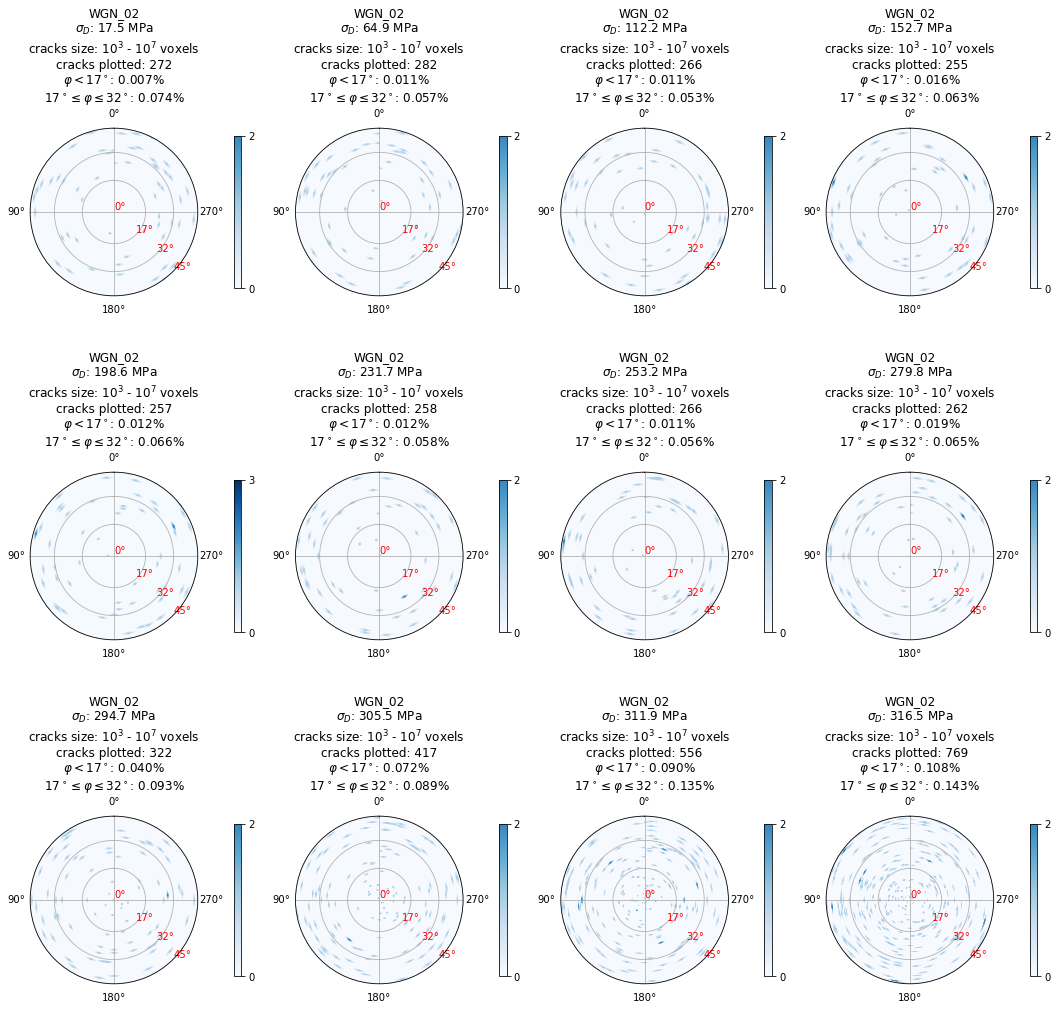

In [72]:
expn = ['WGN_02']
idx_phi=23
idx_vol=4
idx_ani = 5
thr_ani = 0.93
idx_theta=24
idx_diff=2
limvolinf=3
limvolsup=7
step = 7
vmin=0
vmax=3
ext = 17
shrs = 32

sigdx_3_7, phi1_len_3_7, phi1_ext_list_3_7, phi1_shrs_list_3_7, ptg_ext_list_3_7, ptg_shr_list_3_7, vol_fracs_3_7, tot_vol_ext_list_3_7, tot_vol_shrs_list_3_7 = plot_fracture_orientation_largest_eigenvector_step(expn = expn, idx_ani = idx_ani, thr_ani = thr_ani, idx_phi = idx_phi, idx_vol = idx_vol, idx_theta = idx_theta, idx_diff = idx_diff, limvolinf = limvolinf, limvolsup = limvolsup, step =step, vmin = vmin, vmax = vmax, ext = ext, shrs = shrs)



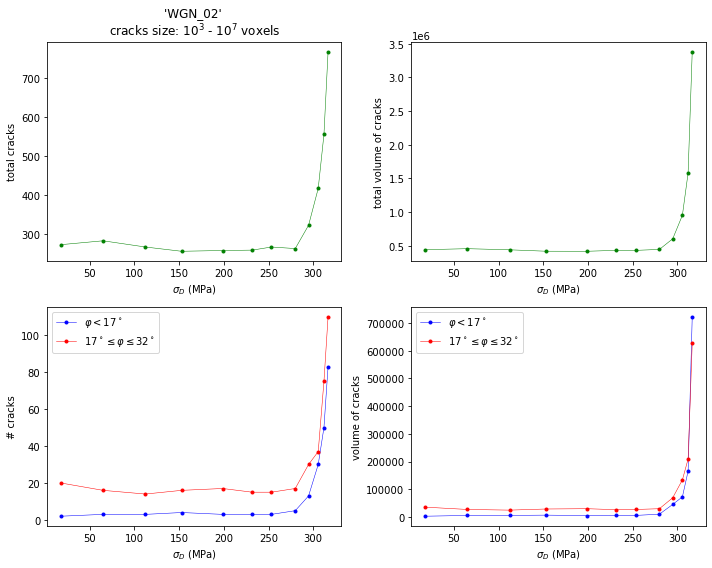

In [73]:
plot_cracks(sigdx = sigdx_3_7, phi_len = phi1_len_3_7, phi1_ext = phi1_ext_list_3_7, phi1_shrs = phi1_shrs_list_3_7, vol_fracs = vol_fracs_3_7, tot_vol_ext = tot_vol_ext_list_3_7, tot_vol_shrs = tot_vol_shrs_list_3_7, expn = expn, limvolinf = limvolinf, limvolsup = limvolsup, ext = ext, shrs =shrs)

In [ ]:
prt = 0.65
plot_cracks_with_vol_fracs(sigdx = sigdx_3_7, phi_len = phi_len_3_7, phi1_ext = phi1_ext_3_7, phi1_shrs = phi1_shrs_3_7, vol_fracs = vol_fracs_3_7, tot_vol_ext = tot_vol_ext_3_7, tot_vol_shrs = tot_vol_shrs_3_7, expn = expn, limvolinf = limvolinf, limvolsup = limvolsup, ext = ext, shrs = shrs, prt = prt):   

In [ ]:
limvolinf=2
limvolsup=7
step = 1
vmin=0
vmax=3

sigdx_2_7, phi1_len_2_7, phi1_ext_list_2_7, phi1_shrs_list_2_7, ptg_ext_list_2_7, ptg_shr_list_2_7, vol_fracs_2_7, tot_vol_ext_list_2_7, tot_vol_shrs_list_2_7 = plot_fracture_orientation_largest_eigenvector_step(expn = expn, idx_ani = idx_ani, thr_ani = thr_ani, idx_phi = idx_phi, idx_vol = idx_vol, idx_theta = idx_theta, idx_diff = idx_diff, limvolinf = limvolinf, limvolsup = limvolsup, step =step, vmin = vmin, vmax = vmax, ext = ext, shrs = shrs)



I would like to try to plot two different plots for extensile and shear fracture orientation, and each plot contains different fracture volumes. 

Ok, now I have:
1. ptg_ext_list_01_5_7, ptg_shr_list_01_5_7
2. ptg_ext_list_01_4_5, ptg_shr_list_01_4_5
3. ptg_ext_list_01_3_4, ptg_shr_list_01_3_4
4. ptg_ext_list_01_2_3, ptg_shr_list_01_2_3
5. ptg_ext_list_01_2_7, ptg_shr_list_01_2_7
6. with corresponding sigdx

I would like to plot all of these data.

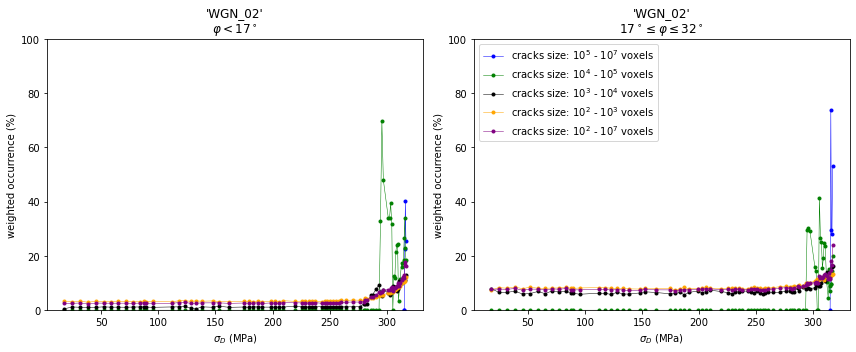

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first column: extensile orientation
axs[0].plot(sigdx_01_5_7, ptg_ext_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
axs[0].plot(sigdx_01_4_5, ptg_ext_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
axs[0].plot(sigdx_01_3_4, ptg_ext_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
axs[0].plot(sigdx_01_2_3, ptg_ext_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
axs[0].plot(sigdx_01_2_7, ptg_ext_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")
axs[0].set_ylim(0, 100)
axs[0].set_ylabel('weighted occurrence (%)')
axs[0].set_xlabel('$\sigma_D$ (MPa)')
axs[0].set_title(f"{str(expn).strip('[]')}\n$\\varphi < {ext}^\\circ$")


# Plotting the second column: shear orientation
axs[1].plot(sigdx_01_5_7, ptg_shr_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
axs[1].plot(sigdx_01_4_5, ptg_shr_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
axs[1].plot(sigdx_01_3_4, ptg_shr_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
axs[1].plot(sigdx_01_2_3, ptg_shr_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
axs[1].plot(sigdx_01_2_7, ptg_shr_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")
axs[1].set_ylim(0, 100)
axs[1].set_ylabel('weighted occurrence (%)')
axs[1].set_xlabel('$\sigma_D$ (MPa)')
axs[1].set_title(f"{str(expn).strip('[]')}\n${ext}^\\circ \leq \\varphi \\leq {shrs}^\\circ$")
axs[1].legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

Figure saved as figs/weighted occurrence_['WGN_02']_anis_no_normphi_extensile.png


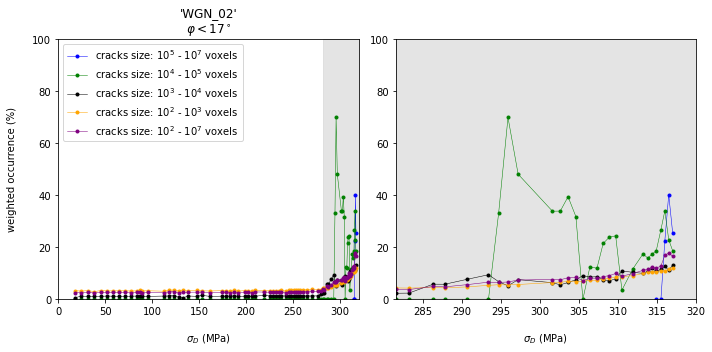

Figure saved as figs/weighted occurrence_['WGN_02']_anis_no_normphi_shear.png


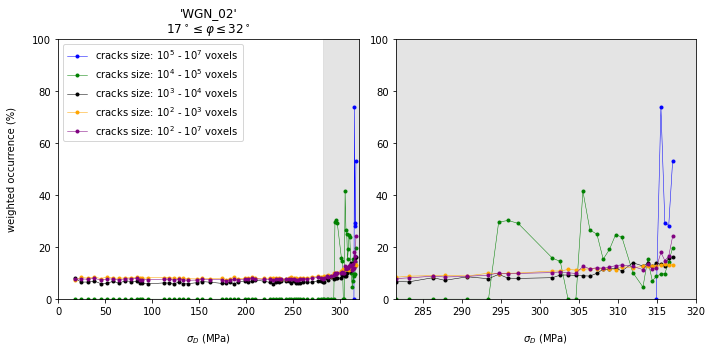

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import ConnectionPatch

# Plotting the extensile orientation
#Full plot
xmin1, xmax1, ymin1, ymax1=0,320,0,100
#Zoom plot
xmin2, xmax2, ymin2, ymax2=sigdx_01_2_7[round(0.63*len(sigdx_01_2_7))],320,0,100

# Create main container with size of 6x5
fig = plt.figure(figsize=(10, 5))

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(1,2,1) # two rows, two columns, fist cell
sub1.plot(sigdx_01_5_7, ptg_ext_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
sub1.plot(sigdx_01_4_5, ptg_ext_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
sub1.plot(sigdx_01_3_4, ptg_ext_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
sub1.plot(sigdx_01_2_3, ptg_ext_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
sub1.plot(sigdx_01_2_7, ptg_ext_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")

sub1.set_xlim(xmin1, xmax1)
sub1.set_ylim(ymin1, ymax1)
sub1.set_ylabel('weighted occurrence (%)', labelpad = 15)
sub1.set_xlabel('$\sigma_D$ (MPa)', labelpad = 15)
sub1.set_title(f"{str(expn).strip('[]')}\n$\\varphi < {ext}^\\circ$")
sub1.legend(loc='upper left')

# Create second axes, the top-left plot with orange plot
sub2 = fig.add_subplot(1,2,2) # two rows, two columns, second cell
sub2.plot(sigdx_01_5_7, ptg_ext_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
sub2.plot(sigdx_01_4_5, ptg_ext_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
sub2.plot(sigdx_01_3_4, ptg_ext_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
sub2.plot(sigdx_01_2_3, ptg_ext_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
sub2.plot(sigdx_01_2_7, ptg_ext_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")

sub2.set_xlim(xmin2, xmax2)
sub2.set_ylim(ymin2, ymax2)
sub2.set_xlabel('$\sigma_D$ (MPa)', labelpad = 15)

# Create blocked area in third axes
x_fill=[xmin2,xmin2,xmax2,xmax2]
y_fill=[ymin2,ymax2,ymax2,ymin2]
sub1.fill(x_fill,y_fill,color='lightgrey',alpha=0.6,label='highlight')
sub2.fill(x_fill,y_fill,color='lightgrey',alpha=0.6,label='highlight')

plt.tight_layout()
output_filename = f'figs/weighted occurrence_{expn}_anis_no_normphi_extensile.png'
plt.savefig(output_filename, dpi=600, bbox_inches='tight')
print(f'Figure saved as {output_filename}')
plt.show()

# Plotting the shear orientation

# Create main container with size of 6x5
fig = plt.figure(figsize=(10, 5))

# Create first axes, the top-left plot with green plot
sub1 = fig.add_subplot(1,2,1) # two rows, two columns, fist cell
sub1.plot(sigdx_01_5_7, ptg_shr_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
sub1.plot(sigdx_01_4_5, ptg_shr_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
sub1.plot(sigdx_01_3_4, ptg_shr_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
sub1.plot(sigdx_01_2_3, ptg_shr_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
sub1.plot(sigdx_01_2_7, ptg_shr_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")

sub1.set_xlim(xmin1, xmax1)
sub1.set_ylim(ymin1, ymax1)
sub1.set_ylabel('weighted occurrence (%)', labelpad = 15)
sub1.set_xlabel('$\sigma_D$ (MPa)', labelpad = 15)
sub1.set_title(f"{str(expn).strip('[]')}\n${ext}^\\circ \leq \\varphi \\leq {shrs}^\\circ$")
sub1.legend(loc='upper left')

# Create second axes, the top-left plot with orange plot
sub2 = fig.add_subplot(1,2,2) # two rows, two columns, second cell
sub2.plot(sigdx_01_5_7, ptg_shr_list_01_5_7, marker='o', linestyle='-', color='b', linewidth=0.5, markersize=3, label = r"cracks size: $10^{5}$ - $10^{7}$ voxels")
sub2.plot(sigdx_01_4_5, ptg_shr_list_01_4_5, marker='o', linestyle='-', color='green', linewidth=0.5, markersize=3, label = r"cracks size: $10^{4}$ - $10^{5}$ voxels")
sub2.plot(sigdx_01_3_4, ptg_shr_list_01_3_4, marker='o', linestyle='-', color='k', linewidth=0.5, markersize=3, label = r"cracks size: $10^{3}$ - $10^{4}$ voxels")
sub2.plot(sigdx_01_2_3, ptg_shr_list_01_2_3, marker='o', linestyle='-', color='orange', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{3}$ voxels")
sub2.plot(sigdx_01_2_7, ptg_shr_list_01_2_7, marker='o', linestyle='-', color='purple', linewidth=0.5, markersize=3, label = r"cracks size: $10^{2}$ - $10^{7}$ voxels")

sub2.set_xlim(xmin2, xmax2)
sub2.set_ylim(ymin2, ymax2)
sub2.set_xlabel('$\sigma_D$ (MPa)', labelpad = 15)

# Create blocked area in third axes
x_fill=[xmin2,xmin2,xmax2,xmax2]
y_fill=[ymin2,ymax2,ymax2,ymin2]
sub1.fill(x_fill,y_fill,color='lightgrey',alpha=0.6,label='highlight')
sub2.fill(x_fill,y_fill,color='lightgrey',alpha=0.6,label='highlight')

plt.tight_layout()
output_filename = f'figs/weighted occurrence_{expn}_anis_no_normphi_shear.png'
plt.savefig(output_filename, dpi=600, bbox_inches='tight')
print(f'Figure saved as {output_filename}')
plt.show()